In [20]:
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
from collections import deque

# input: the number of observations 3*3 
# output: prob of each action (n_acts)
class CategoricalMLP(nn.Module):
    def __init__(self, n_obs:int, n_acts:int):
        super(CategoricalMLP, self).__init__()
        self.layer1 = nn.Linear(n_obs, 128)
        self.layer2 = nn.Linear(128, n_acts)
        self.tanh_activation = nn.Tanh()
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.tanh_activation(x)
        x = self.layer2(x)
        x = Categorical(logits=x)
        return x

In [23]:
# Create a maze
# All four boundaries are walls (maze[i][j] = 1 if blocked)

N = 9
maze = [[1 if i in [0, N-1] or j in [0, N-1] else 0 for i in range(N)] for j in range(N)]
K = 10
for _ in range(K):
    i, j = random.randint(1, N-2), random.randint(1, N-2)
    maze[i][j] = 1
maze[1][1] = 0
maze[N-2][N-2] = 0

# Enter from 1,1
x, y = 1, 1
D = [(1,0),(-1,0),(0,-1),(0,1)]
def move(i):
    global x,y,D,N
    xx = x + D[i][0]
    yy = y + D[i][1]
    if maze[xx][yy] != 1:
        x, y = xx, yy
    if x == N-2 and y == N-2:  # Exit from N-2,N-2
        return 1
    return 0

for i in range(N):
    print(maze[i])

[1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 0, 0, 0, 0, 1, 0, 0, 1]
[1, 0, 0, 0, 1, 0, 0, 0, 1]
[1, 0, 0, 1, 0, 0, 0, 0, 1]
[1, 0, 0, 0, 0, 0, 0, 1, 1]
[1, 0, 0, 0, 0, 0, 0, 1, 1]
[1, 0, 0, 0, 0, 0, 1, 0, 1]
[1, 0, 0, 0, 1, 0, 0, 0, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1]


In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Number of observations (3*3 local grid)
n_obs=3*3
# Number of actions (Go up, Go down, Go left, Go right)
n_acts=len(D)

policy_net = CategoricalMLP(n_obs, n_acts).to(device)
optimizer = optim.Adam(policy_net.parameters(), lr=3e-3)

# Observations, the local 3*3 grid
def sub_maze(x, y):
    global maze, N
    sub = []
    for i in [x-1, x, x+1]:
        for j in [y-1, y, y+1]:
            if 0 <= i < N and 0 <= j < N:
                sub.append(maze[i][j])
            else:
                sub.append(1)
    return torch.as_tensor(sub, dtype=torch.float32).to(device)

epochs = 10000
sum_steps_list = 0
step_list = []
for epoch in range(epochs):
    x, y = 1, 1
    loss = 0
    steps = 0
    max_steps = N * 5
    while steps < max_steps: # truncate if stuck
        dist = policy_net(sub_maze(x, y))
        action = dist.sample()
        logp = dist.log_prob(action)

        loss += - logp
        if move(action.item()) == 1:  # reach exit
            break
        steps += 1

    # truncated by max steps, did not reach exit
    if steps == max_steps:
        loss *= -1.

    optimizer.zero_grad() 
    loss.backward()
    optimizer.step()

    step_list.append(steps)
    sum_steps_list += steps
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: steps={steps}, ends at {x, y}, average steps {sum_steps_list / len(step_list)}")

Epoch 0: steps=45, ends at (2, 2), average steps 45.0
Epoch 500: steps=18, ends at (7, 7), average steps 33.19760479041916
Epoch 1000: steps=19, ends at (7, 7), average steps 28.716283716283716
Epoch 1500: steps=15, ends at (7, 7), average steps 26.216522318454363
Epoch 2000: steps=14, ends at (7, 7), average steps 24.152923538230883
Epoch 2500: steps=13, ends at (7, 7), average steps 22.736505397840865
Epoch 3000: steps=32, ends at (7, 7), average steps 21.994001999333555
Epoch 3500: steps=14, ends at (7, 7), average steps 21.422165095686946
Epoch 4000: steps=19, ends at (7, 7), average steps 21.12296925768558
Epoch 4500: steps=13, ends at (7, 7), average steps 20.389691179737834
Epoch 5000: steps=20, ends at (7, 7), average steps 19.99540091981604
Epoch 5500: steps=14, ends at (7, 7), average steps 19.55898927467733
Epoch 6000: steps=13, ends at (7, 7), average steps 19.21963006165639
Epoch 6500: steps=15, ends at (7, 7), average steps 18.786955852945702
Epoch 7000: steps=13, ends at

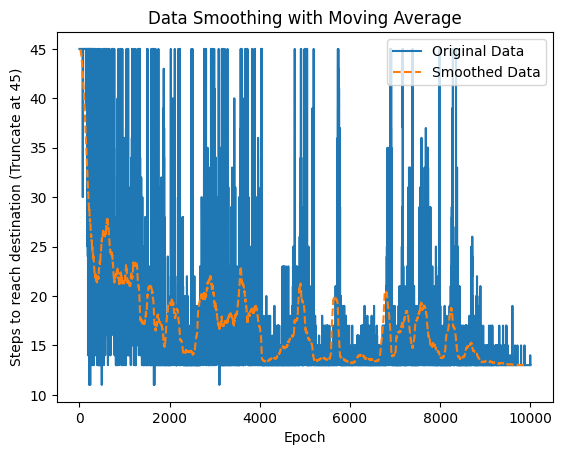

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Original data
data = step_list

# Moving average function
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Apply moving average
smoothed_data = moving_average(data, window_size=150)

# Plot original and smoothed data
plt.plot(data, label="Original Data")
plt.plot(range(1, len(smoothed_data) + 1), smoothed_data, label="Smoothed Data", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel(f"Steps to reach destination (Truncate at {max_steps})")
plt.legend()
plt.title("Data Smoothing with Moving Average")
plt.show()

In [31]:
# This is a test run.
# Model guided the player to go from (1,1) to (N-2,N-2).
x, y = 1, 1
steps = 0
max_steps = N * 4
while steps < max_steps: # truncate if stuck
    
    dist = policy_net(sub_maze(x, y))
    action = dist.sample()
    logp = dist.log_prob(action)

    print(f"step: {steps}, {x, y}")
    steps += 1
    if move(action.item()) == 1:
        print(f"step: {steps}, {x, y}")
        break


step: 0, (1, 1)
step: 1, (2, 1)
step: 2, (3, 1)
step: 3, (4, 1)
step: 4, (5, 1)
step: 5, (6, 1)
step: 6, (7, 1)
step: 7, (7, 2)
step: 8, (7, 3)
step: 9, (6, 3)
step: 10, (6, 4)
step: 11, (6, 5)
step: 12, (7, 5)
step: 13, (7, 6)
step: 14, (7, 7)


In [33]:
# what is the most likely direction to go from each position?

D_sign = ['v', '^', '<', '>']

for i in range(N):
    for j in range(N):
        if maze[i][j] == 0:
            dist = policy_net(sub_maze(i, j))
            best_action = torch.argmax(dist.probs).item()
            print(D_sign[best_action], ' ', end='')
        else:
            print(1, ' ', end='')
    print()


1  1  1  1  1  1  1  1  1  
1  v  v  >  v  1  v  v  1  
1  v  >  ^  1  v  v  ^  1  
1  v  v  1  v  v  >  >  1  
1  v  v  v  v  v  ^  1  1  
1  v  v  v  v  >  >  1  1  
1  v  v  >  >  v  1  v  1  
1  >  >  ^  1  >  >  ^  1  
1  1  1  1  1  1  1  1  1  
